# MAGNIMIND PROJECT 1
### **Ad A/B Testing**
https://www.kaggle.com/datasets/osuolaleemmanuel/ad-ab-testing/code

This is the first draft of a working cod on data cleaning, visual analysis and statistical analysis for A/B testing of above kaggle data set.

### **Imports**

In [1]:
from math import  sqrt

import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

In [2]:
df = pd.read_csv('ABdata.csv')

In [3]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [4]:
df.shape #, df.dtypes

(8077, 9)

In [5]:
df.columns

Index(['auction_id', 'experiment', 'date', 'hour', 'device_make',
       'platform_os', 'browser', 'yes', 'no'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


Lets check if there are any dublicated data via checking on auction_id column

In [7]:
num_duplicates = sum(df.duplicated(subset=['auction_id']))
num_duplicates

0

In [8]:
df.isnull().values.any() , df.isna().values.any()

(False, False)

There are no dublicated data, no null or NA values in data.

In [9]:
respond_table = df.groupby(['experiment'])[['yes','no']].sum(numeric_only=True)
respond_table

,yes,no
experiment,,
control,264,322
exposed,308,349


### **Preprocessing**

First off all, lets convert date column to datetime format

In [10]:
# convert the 'date' column to datetime format
df['date']= pd.to_datetime(df['date'])
df['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8077 entries, 0 to 8076
Series name: date
Non-Null Count  Dtype         
--------------  -----         
8077 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 63.2 KB


lets split device_make column into a 'device' column and a 'model' column:

In [11]:
df[['device', 'model']] = df['device_make'].str.split(n=1, expand=True)

In [12]:
df.columns

Index(['auction_id', 'experiment', 'date', 'hour', 'device_make',
       'platform_os', 'browser', 'yes', 'no', 'device', 'model'],
      dtype='object')

Lets drop the columns that wont be used for analysis

In [13]:
df2 = df[['experiment', 'yes', 'no', 'date', 'hour', 'device', 'model', 'browser']]

In [14]:
df2.head()

,experiment,yes,no,date,hour,device,model,browser
0,exposed,0,0,2020-07-10,8,Generic,Smartphone,Chrome Mobile
1,exposed,0,0,2020-07-07,10,Generic,Smartphone,Chrome Mobile
2,exposed,0,1,2020-07-05,2,E5823,None,Chrome Mobile WebView
3,control,0,0,2020-07-03,15,Samsung,SM-A705FN,Facebook
4,control,0,0,2020-07-03,15,Generic,Smartphone,Chrome Mobile


Let's split the data into two parts now, those who responded and those havent

As a sanity check lets look for data with both yes and no response ( which shouldn't happen )

In [15]:
df2[((df2['yes']==1)&(df2['no']==1))].sum(numeric_only=True)

yes     0.0
no      0.0
hour    0.0
dtype: float64

In [16]:
df_response = df2[~((df2['yes']== 0) & (df2['no']== 0))]
df_Noresponse =  df2[(df2['yes']== 0) & (df2['no']== 0)]

### **Data analysis**

In [17]:
df_response.shape , df_Noresponse.shape

((1243, 8), (6834, 8))

As we can see majority of people havent participated at all

In [18]:
print(f"{(1-df_response.shape[0]/df_Noresponse.shape[0]):.2%} of people havent participated at all")

81.81% of people havent participated at all


In [19]:
df_response['experiment'].value_counts()

exposed    657
control    586
Name: experiment, dtype: int64

<Axes: ylabel='experiment'>

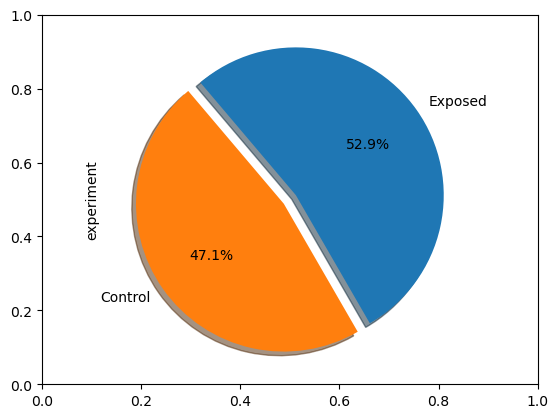

In [20]:
plt.axes().set_ylabel('')
plt.axes().set_xlabel('')

df_response['experiment'].value_counts()\
.plot.pie(explode=[0.05,0.05], labels=['Exposed','Control'], autopct='%1.1f%%', shadow=True, startangle=-60)

> https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f

In [21]:
respond_table = df.groupby(['experiment'])[['yes','no']].sum(numeric_only=True)
respond_table['sum'] = respond_table.apply(lambda row: row['yes']+row['no'],axis=1)
respond_table

,yes,no,sum
experiment,,,
control,264,322,586
exposed,308,349,657


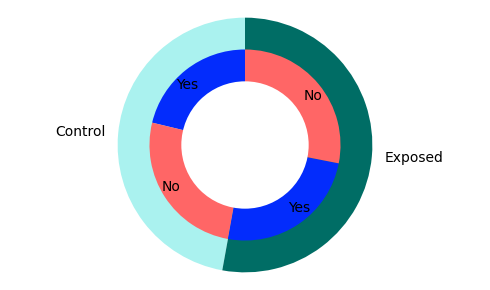

In [22]:
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(3)

labels = ['Control', 'Exposed']
sizes = [586,657]
labels_yesno = ['Yes','No','Yes','No']
sizes_yesno = [264,322,308,349]
colors = ['#aaf2ef','#006d65']
colors_yesno= ['#032cfc','#ff6666','#032cfc','#ff6666']
 
plt.pie(sizes, labels=labels, colors=colors, startangle=90,frame=True)
plt.pie(sizes_yesno,labels=labels_yesno, colors=colors_yesno,radius=0.75,startangle=90, labeldistance=0.8) # pctdistance=0.1,
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

lets make the same table for overall user avtivity.  Make a new columns answer which will be 1 for engaging with questioneer button and zero for not engaging.

In [86]:
df['interacted'] = df.apply(lambda row:row['yes']+row['no'],axis=1)
#df.head()

In [89]:
overall_respond_table = df.groupby(['experiment'])[['interacted']].sum(numeric_only=True)
overall_respond_table['overall_sum'] = df.groupby(['experiment'])[['experiment']].count()
overall_respond_table['not_interacted'] = overall_respond_table['overall_sum']-overall_respond_table['interacted']
overall_respond_table

,interacted,overall_sum,not_interacted
experiment,,,
control,586,4071,3485
exposed,657,4006,3349


In [90]:
overall_respond_table = overall_respond_table[['interacted','not_interacted','overall_sum']]
overall_respond_table

,interacted,not_interacted,overall_sum
experiment,,,
control,586,3485,4071
exposed,657,3349,4006


In [83]:
#df2.info()

In [109]:
# df_mod = df2.drop(df2.columns[[0, 5]], axis=1, inplace=False)
# df_mod.info() # df_modified

## **Statistical analysis** Part 1

First problem we want to answer is whether or not the new Ad contributed to a higher click rate or not. For This we will use  several different statistical tests. Our contingency table looks like as follows:


In [25]:
respond_table

,yes,no,sum
experiment,,,
control,264,322,586
exposed,308,349,657


#### **Case 1: Chi Square Test**

The chi-squared test is a statistical test that can be used for A/B testing to determine if there is a statistically significant difference between two proportions or percentages. It is commonly used in A/B testing to analyze the results of a randomized experiment where a control group and a treatment group are compared.

To conduct a chi-squared test, the following steps can be taken:

Define the null hypothesis and alternative hypothesis:\
Null hypothesis: There is no statistically significant difference between the conversion rates of the control group and the treatment group.\
Alternative hypothesis: There is a statistically significant difference between the conversion rates of the control group and the treatment group.
    
$$
\begin{cases}
    H_0:& p_{con}=p_{exp}\\
    H_1: &p_{con}\neq p_{exp}
\end{cases}
$$

Set the level of significance (alpha):
This is the threshold probability value below which the null hypothesis is rejected. Common values for alpha are 0.05 or 0.01.

Collect the data: Record the number of conversions and non-conversions for both the control and treatment groups.

Calculate the expected values: Calculate the expected number of conversions and non-conversions for both the control and treatment groups, assuming that there is no significant difference between the groups. This is done by multiplying the total number of observations by the proportion of conversions/non-conversions in each group.

Calculate the chi-squared test statistic: The chi-squared test statistic measures the difference between the observed values and the expected values. It is calculated as the sum of [(observed value - expected value)^2 / expected value] for all four possible outcomes (conversion/non-conversion in control/treatment group).

Calculate the degrees of freedom: The degrees of freedom for the chi-squared test in A/B testing is 1, since there are only two groups being compared.

Determine the p-value: The p-value is the probability of obtaining a chi-squared test statistic as extreme or more extreme than the observed value, assuming that the null hypothesis is true.

Compare the p-value to the level of significance: If the p-value is less than the level of significance, the null hypothesis is rejected, and it can be concluded that there is a statistically significant difference between the conversion rates of the control and treatment groups.

In conclusion, the chi-squared test can be used to analyze the results of an A/B test and determine if there is a statistically significant difference between the conversion rates of the control and treatment groups.

In [26]:
from scipy.stats import chi2_contingency

In [27]:
# Create the contingency table as a 2D numpy array
cont_table = np.array([[264, 322], [308, 349]])
cont_table

array([[264, 322],
       [308, 349]])

In [28]:
# Perform the chi-square test
%time
chi2, pval_chi2, dof_chi2, expected = chi2_contingency(cont_table)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


In [29]:
# Print the results
print(f"Chi-square: {chi2:.2f}")
print(f"P-value: {pval_chi2:.3f}")
print(f"Degree of freedom: {dof_chi2:.2f}")
print("Expected value of frequencies under null hypothesis: ")
print(expected)

Chi-square: 0.35
P-value: 0.556
Degree of freedom: 1.00
Expected value of frequencies under null hypothesis: 
[[269.66371681 316.33628319]
 [302.33628319 354.66371681]]


The null hypothesis for a chi-square test on a contingency table is that there is no association between the two categorical variables. In other words, the observed frequencies in the contingency table are not significantly different from the expected frequencies under the assumption of independence between the two variables.

In this case, our p-value is greater than 0.05, which means we fail to reject the null hypothesis. Therefore, we conclude that there is not enough evidence to suggest that there is a significant association between the two categorical variables represented in the contingency table.

#### **Case 2: Fisher's Exact test**

Fisher's exact test is a good when the sample size is small or the expected cell frequencies are low (i.e. <5). The chi-square test is generally preferred over Fisher's exact test because the chi-square test has more power to detect smaller differences between the groups. Still we will perform the test to see what it tells us.

In [30]:
from scipy.stats import fisher_exact

# Perform Fisher's exact test
odds_ratio_fisher, pval_fisher = fisher_exact(cont_table)

# Print the results
print(f"Odds ratio: {odds_ratio_fisher:.2f}")
print(f"P-value: {pval_fisher:.3f}")

Odds ratio: 0.93
P-value: 0.531


The null hypothesis for Fisher's exact test is the same as for the chi-square test: there is no association between the two categorical variables. In other words, the odds of one category of the first variable occurring in combination with one category of the second variable are not significantly different from the expected odds under the assumption of independence between the two variables.

In this case, the p-value for Fisher's exact test is also greater than 0.05, which means we fail to reject the null hypothesis. Therefore, we conclude that there is not enough evidence to suggest that there is a significant association between the two categorical variables represented in the contingency table.

> https://en.wikipedia.org/wiki/Click-through_rate

> https://en.wikipedia.org/wiki/Fisher%27s_exact_test


#### **Case 3: Z-test for comparing proportions (2-sided)**

The Z test is a statistical test that can be used for A/B testing to determine if there is a statistically significant difference between the proportions or percentages of two groups. It is commonly used when the sample size is large (typically greater than 30) and the data is normally distributed.

To conduct a Z test for A/B testing, the following steps can be taken:

Define the null hypothesis and alternative hypothesis: 
Null hypothesis: There is no statistically significant difference between the conversion rates of the control group and the treatment group.
Alternative hypothesis: There is a statistically significant difference between the conversion rates of the control group and the treatment group.

$$
  \begin{cases}
    H_0:& p_{con}=p_{exp}\\
    H_1: &p_{con}\neq p_{exp}
\end{cases}
$$


Set the level of significance (alpha): This is the threshold probability value below which the null hypothesis is rejected. Common values for alpha are 0.05 or 0.01.

Collect the data: Record the number of conversions and non-conversions for both the control and treatment groups.

Calculate the pooled proportion: Calculate the proportion of conversions across both the control and treatment groups. This is called the pooled proportion and is calculated as
$$\hat p_{p}=\frac{X_{con}+X_{exp}}{N_{con}+N_{exp}}$$

Calculate the standard error: The standard error is a measure of the variability of the sample data. It is calculated as:
$$\hat s_p^2 =\hat p_p (1-\hat p_p)\times (\frac{1}{N_{con}}+\frac{1}{N_{exp}})$$
where n1 and n2 are the sample sizes of the control and treatment groups, respectively.

Calculate the test statistic: The test statistic is calculated as the difference between the sample proportions of the control and treatment groups divided by the standard error. It is expressed as:
$$Z=\frac{\hat p_{con}-\hat p_{exp}}{\sqrt{\hat s_p^2}}$$
where p1 and p2 are the sample proportions of the control and treatment groups, respectively, and SE is the standard error.

Calculate the critical value: The critical value is the value that separates the rejection region from the non-rejection region. For a two-sided test with alpha = 0.05, the critical value is 1.96.

Determine the p-value: The p-value is the probability of obtaining a test statistic as extreme or more extreme than the observed value, assuming that the null hypothesis is true. In a two-sided test, the p-value is calculated as twice the area under the normal distribution curve to the left of the negative of the absolute value of the test statistic.
$$p_{value} = Pr[t\leq Z \text{ or } t\geq Z]=2 \times Pr[t \geq Z] $$

Compare the p-value to the level of significance: If the p-value is less than the level of significance, the null hypothesis is rejected, and it can be concluded that there is a statistically significant difference between the conversion rates of the control and treatment groups.

In conclusion, the Z test can be used to analyze the results of an A/B test and determine if there is a statistically significant difference between the conversion rates of the control and treatment groups when the sample size is large and the data is normally distributed. It provides a simple way to compare two proportions and determine if they are significantly different from each other.

In [31]:
respond_table

,yes,no,sum
experiment,,,
control,264,322,586
exposed,308,349,657


null hypothesis is valid
Test Statistics stat:  -0.645680181221037
Z-critical:  1.959963984540054
P_value:  1.4815135017801033
Confidence Interval of 2 sample Z-test for proportions:  [-0.07  0.04]


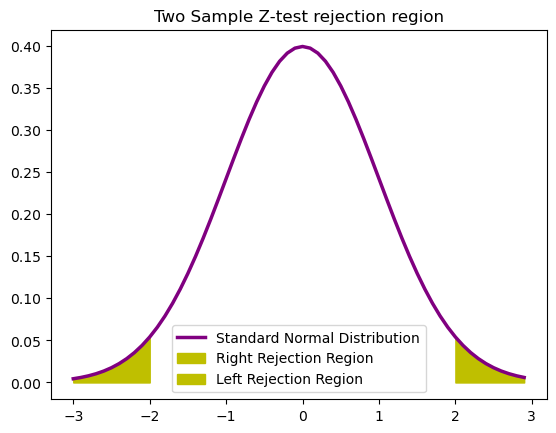

In [32]:
from scipy.stats import norm

X_con = 264 #clicks control
N_con = 586 #impressions control
X_exp = 308 #clicks experimental
N_exp = 657 #impressions experimetal

# Significance Level
alpha = 0.05

p_con_hat = X_con / N_con
p_exp_hat = X_exp / N_exp

p_pooled_hat = (X_con + X_exp)/(N_con + N_exp)
pooled_variance = p_pooled_hat*(1-p_pooled_hat) * (1/N_con + 1/N_exp)

# Standard Error
SE = np.sqrt(pooled_variance)

# test statsitics
Test_stat = (p_con_hat - p_exp_hat)/SE
# critical value usig the standard normal distribution
Z_crit = norm.ppf(1-alpha/2)

# Margin of error
m = SE * Z_crit
# two sided test and using symmetry property of Normal distibution so we multiple with 2
p_value = norm.sf(Test_stat)*2

# Confidence Interval
CI = [(p_con_hat-p_exp_hat) - SE * Z_crit, (p_con_hat-p_exp_hat) + SE * Z_crit]

if np.abs(Test_stat) >= Z_crit:
    print("reject the null")
    print(p_value)
else:
    print("null hypothesis is valid")

print("Test Statistics stat: ", Test_stat)
print("Z-critical: ", Z_crit)
print("P_value: ", p_value)
print("Confidence Interval of 2 sample Z-test for proportions: ", np.round(CI,2))

import matplotlib.pyplot as plt
z = np.arange(-3,3,  0.1)
plt.plot(z, norm.pdf(z), label = 'Standard Normal Distribution',color = 'purple',linewidth = 2.5)
plt.fill_between(z[z>Z_crit], norm.pdf(z[z>Z_crit]), label = 'Right Rejection Region',color ='y' )
plt.fill_between(z[z<(-1)*Z_crit], norm.pdf(z[z<(-1)*Z_crit]), label = 'Left Rejection Region',color ='y' )
plt.title("Two Sample Z-test rejection region")
plt.legend()
plt.show()

Simulation for the power of test

In [33]:
# Set the parameters for the null hypothesis
X_con, N_con = 264, 586
p_con = X_con / N_con

# Set the parameters for the alternative hypothesis
X_exp, N_exp = 308, 657
p_exp = X_exp / N_exp

# Set the significance level
alpha = 0.05

# Calculate the standard error of the difference in proportions
se_diff = np.sqrt(p_con * (1 - p_con) / N_con + p_exp * (1 - p_exp) / N_exp)

# Calculate the critical values for a two-sided test
z_alpha_2 = norm.ppf(1 - alpha/2)

# Calculate the minimum detectable effect size (MDES)
mdes = se_diff * z_alpha_2

# Calculate the observed effect size (OES)
oes = np.abs(p_exp - p_con)

# Calculate the power of the test
z_beta = norm.ppf(1 - alpha/2) - oes / se_diff
power = norm.cdf(z_beta + mdes) - norm.cdf(-z_beta - mdes)

# Print the results
print(f"Null hypothesis: p_con = {p_con:.3f}")
print(f"Alternative hypothesis: p_exp = {p_exp:.3f}")
print(f"Significance level: alpha = {alpha}")
print(f"Critical values: +/- {z_alpha_2:.3f}")
#print(f"se difference: {se_diff}")
print(f"Minimum detectable effect size: {mdes:.3f}")
print(f"Observed effect size: {oes:.3f}")
print(f"Power of the test: {power:.3f}")

Null hypothesis: p_con = 0.451
Alternative hypothesis: p_exp = 0.469
Significance level: alpha = 0.05
Critical values: +/- 1.960
Minimum detectable effect size: 0.055
Observed effect size: 0.018
Power of the test: 0.829


As shown in results although power of the test is above 80% , the observed effect size of 0.018 is lower than  the theoratical minimum detectable effect size of 0.055

Lets simulate a power analysis of a 2 sided Z test below:

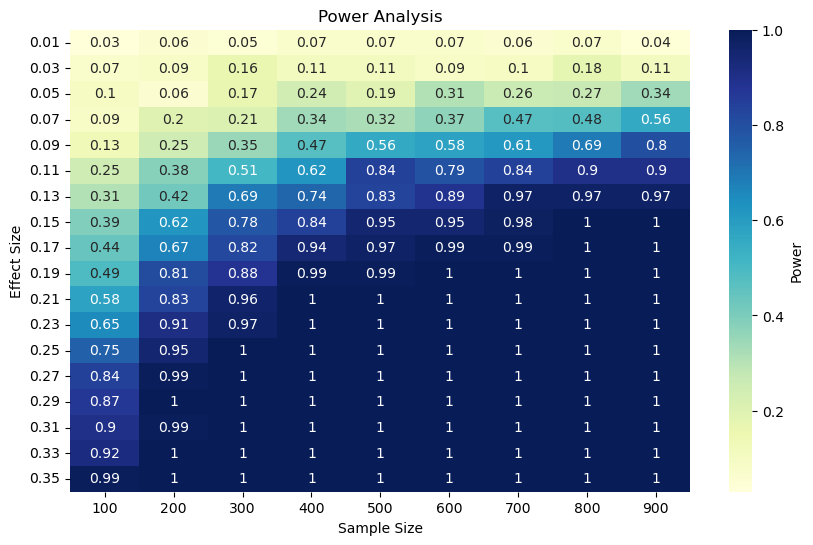

In [34]:
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns

# Define the control and experimental groups
X_con, N_con = 264, 586
X_exp, N_exp = 308, 657

# Calculate the pooled proportion
p_pool = (X_con + X_exp) / (N_con + N_exp)

# Set the parameters for the simulation
alpha = 0.05
simulations = 100
effect_sizes = np.arange(0.01, .36, 0.02)
sample_sizes = np.arange(100, 1000, 100)

# Create a matrix to store the power for different effect sizes and sample sizes
power_matrix = np.zeros((len(effect_sizes), len(sample_sizes)))

# Simulate the power for different effect sizes and sample sizes
for i, effect_size in enumerate(effect_sizes):
    for j, sample_size in enumerate(sample_sizes):
        significant_count = 0
        for k in range(simulations):
            # Simulate data with the given effect size and sample size
            p_con = p_pool - 0.5 * effect_size
            p_exp = p_pool + 0.5 * effect_size
            n_con_sim = sample_size // 2
            n_exp_sim = sample_size - n_con_sim
            X_con_sim = np.random.binomial(n_con_sim, p_con)
            X_exp_sim = np.random.binomial(n_exp_sim, p_exp)

            # Calculate the two-sided Z-test and its p-value
            count = np.array([X_con_sim, X_exp_sim])
            nobs = np.array([n_con_sim, n_exp_sim])
            z_stat, p_val = proportions_ztest(count, nobs)

            # Check if the p-value is less than the significance level
            if p_val < alpha:
                significant_count += 1

        # Calculate the power of the test
        power = significant_count / simulations
        power_matrix[i, j] = power

# Convert the matrix to a DataFrame for visualization
df_power = pd.DataFrame(power_matrix, index=effect_sizes.round(3), columns=sample_sizes)
df_power.style.background_gradient(cmap='YlGnBu', vmin=0, vmax=1).format("{:.3f}")
# Create the heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(df_power, annot=True, cmap='YlGnBu', fmt='.3g', cbar_kws={'label': 'Power'})
ax.set_title('Power Analysis')
ax.set_xlabel('Sample Size')
ax.set_ylabel('Effect Size')
plt.yticks(rotation=0)
plt.show()

In [55]:
p_con = X_con/N_con
p_con

0.45051194539249145

In [56]:
p_exp = X_exp/N_exp
p_exp

0.4687975646879756

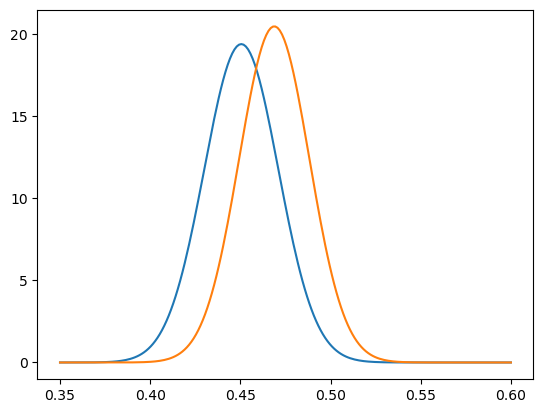

In [103]:
std_a=np.sqrt(p_con * (1-p_con)/N_con)
std_b=np.sqrt(p_exp * (1-p_exp)/N_exp)

click_rate = np.linspace(0.35, 0.6, 200)
prob_a = norm(p_con, std_a).pdf(click_rate)
prob_b = norm(p_exp, std_b).pdf(click_rate)

plt.plot(click_rate, prob_a, label='A')
plt.plot(click_rate, prob_b, label='B')

In [61]:
z_score_for_test = (p_exp-p_con)/np.sqrt(std_a**2+std_b**2)
z_score_for_test

0.6458981015684259

In [63]:
test_statistics_p = 1-norm().cdf(z_score_for_test)
test_statistics_p

0.2591726745827285

Conclusion:
p=0.259 so p>0.05, we can not reject the null hypothesis and conclude that there is no statistically significant difference between the AdA and AdB

## **Statistical analysis** Part 2

lets focus on the other part of the problem. Most of the users didnt even bother to interact with the survey button at all. Lets figure out whats going on in that area.

In [91]:
overall_respond_table

,interacted,not_interacted,overall_sum
experiment,,,
control,586,3485,4071
exposed,657,3349,4006


In [92]:
# Create the contingency table as a 2D numpy array
cont_table_2 = np.array([[586, 3485], [657, 3349]])
cont_table_2

array([[ 586, 3485],
       [ 657, 3349]])

reject the null
1.987505360897848
Test Statistics stat:  -2.4978575502090976
Z-critical:  1.959963984540054
P_value:  1.987505360897848
Confidence Interval of 2 sample Z-test for proportions:  [-0.04 -0.  ]


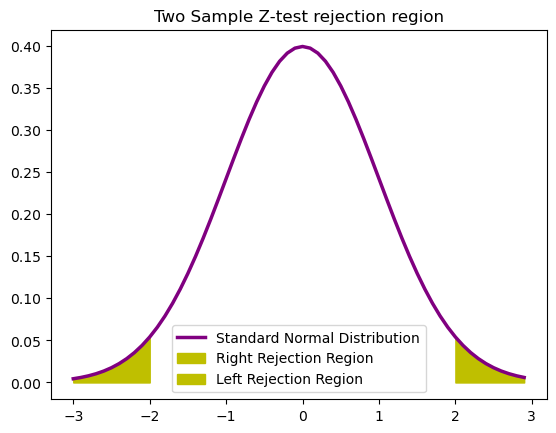

In [94]:
X_con_2 = 586 #clicks control
N_con_2 = 4071 #impressions control
X_exp_2 = 657 #clicks experimental
N_exp_2 = 4006 #impressions experimetal

# Significance Level
alpha = 0.05

p_con_hat_2 = X_con_2 / N_con_2
p_exp_hat_2 = X_exp_2 / N_exp_2

p_pooled_hat_2 = (X_con_2 + X_exp_2)/(N_con_2 + N_exp_2)
pooled_variance_2 = p_pooled_hat_2*(1-p_pooled_hat_2) * (1/N_con_2 + 1/N_exp_2)

# Standard Error
SE_2 = np.sqrt(pooled_variance_2)

# test statsitics
Test_stat_2 = (p_con_hat_2 - p_exp_hat_2)/SE_2
# critical value usig the standard normal distribution
Z_crit_2 = norm.ppf(1-alpha/2)

# Margin of error
m_2 = SE_2 * Z_crit_2
# two sided test and using symmetry property of Normal distibution so we multiple with 2
p_value_2 = norm.sf(Test_stat_2)*2

# Confidence Interval
CI_2 = [(p_con_hat_2-p_exp_hat_2) - SE_2 * Z_crit_2, (p_con_hat_2-p_exp_hat_2) + SE_2 * Z_crit_2]

if np.abs(Test_stat_2) >= Z_crit_2:
    print("reject the null")
    print(p_value_2)
else:
    print("null hypothesis is valid")

print("Test Statistics stat: ", Test_stat_2)
print("Z-critical: ", Z_crit_2)
print("P_value: ", p_value_2)
print("Confidence Interval of 2 sample Z-test for proportions: ", np.round(CI_2,2))

import matplotlib.pyplot as plt
z = np.arange(-3,3,  0.1)
plt.plot(z, norm.pdf(z), label = 'Standard Normal Distribution',color = 'purple',linewidth = 2.5)
plt.fill_between(z[z>Z_crit_2], norm.pdf(z[z>Z_crit_2]), label = 'Right Rejection Region',color ='y' )
plt.fill_between(z[z<(-1)*Z_crit_2], norm.pdf(z[z<(-1)*Z_crit_2]), label = 'Left Rejection Region',color ='y' )
plt.title("Two Sample Z-test rejection region")
plt.legend()
plt.show()

In [98]:
# Set the parameters for the null hypothesis
X_con_2, N_con_2 = 586, 4071
p_con_2 = X_con_2 / N_con_2

# Set the parameters for the alternative hypothesis
X_exp_2 , N_exp_2 = 657, 4006
p_exp_2 = X_exp_2 / N_exp_2

# Set the significance level
alpha = 0.05

# Calculate the standard error of the difference in proportions
se_diff_2 = np.sqrt(p_con_2 * (1 - p_con_2) / N_con_2 + p_exp_2 * (1 - p_exp_2) / N_exp_2)

# Calculate the critical values for a two-sided test
z_alpha_2_2 = norm.ppf(1 - alpha/2)

# Calculate the minimum detectable effect size (MDES)
mdes_2 = se_diff_2 * z_alpha_2_2

# Calculate the observed effect size (OES)
oes_2 = np.abs(p_exp_2 - p_con_2)

# Calculate the power of the test
z_beta_2 = norm.ppf(1 - alpha/2) - oes_2 / se_diff_2
power_2 = -norm.cdf(z_beta_2 + mdes_2) + norm.cdf(-z_beta_2 - mdes_2)
# Print the results
print(f"Null hypothesis: p_con = {p_con_2:.3f}")
print(f"Alternative hypothesis: p_exp = {p_exp_2:.3f}")
print(f"Significance level: alpha = {alpha}")
print(f"Critical values: +/- {z_alpha_2_2:.3f}")
#print(f"se difference: {se_diff}")
print(f"Minimum detectable effect size: {mdes_2:.3f}")
print(f"Observed effect size: {oes_2:.3f}")
print(f"Power of the test: {power_2:.3f}")

Null hypothesis: p_con = 0.144
Alternative hypothesis: p_exp = 0.164
Significance level: alpha = 0.05
Critical values: +/- 1.960
Minimum detectable effect size: 0.016
Observed effect size: 0.020
Power of the test: 0.398


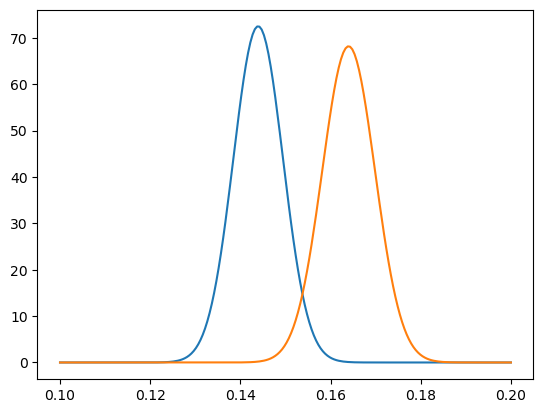

In [105]:
std_a_2=np.sqrt(p_con_2 * (1-p_con_2)/N_con_2)
std_b_2=np.sqrt(p_exp_2 * (1-p_exp_2)/N_exp_2)

click_rate_2 = np.linspace(0.1, 0.2, 200)
prob_a_2 = norm(p_con_2, std_a_2).pdf(click_rate_2)
prob_b_2 = norm(p_exp_2, std_b_2).pdf(click_rate_2)

plt.plot(click_rate_2, prob_a_2, label='A')
plt.plot(click_rate_2, prob_b_2, label='B')

In [106]:
z_score_for_test_2 = (p_exp_2-p_con_2)/np.sqrt(std_a_2**2+std_b_2**2)
z_score_for_test_2

2.4977507989609387

In [107]:
test_statistics_p_2 = 1-norm().cdf(z_score_for_test_2)
test_statistics_p_2

0.00624920101464177

test_statistics_p_2 < 0.05 so we can say that the new add causes more interaction with the survey button. although the interaction rate is only 2 percent higher with new add its a statistically significant difference.

## **Future Work**

-- At a given day/time there are too many data points. Investigate what that means and how that effects the data

-- Use logistic regression as an analysis tool

-- Analyse effects of different phone or software enviroment on interaction effect and so on.

-- Add more visuals